
###Redes Recorentes

O Mercado Futuro é o ambiente onde você pode ganhar com a alta ou baixa de um determinado ativo, seja ele uma commodity (Milho, Café, Boi Gordo), uma moeda (como o dólar), um Índice (Bovespa, Índice S&P 500) ou mesmo uma taxa de juros. Nele, são negociados contratos futuros.

<br><img src="grafico.jpeg"><br>

O mini índice é um contrato futuro derivado do Índice Bovespa, ou seja, é um ativo que tem como base o sobe e desce desse índice. Como esse tipo de operação envolve **risco considerável** e **oscilações frequentes no mercado**, ela é indicada apenas para aqueles que se encaixam no perfil de investidor arrojado.

Neste trabalho iremos implementar uma RNNs para realizar a predição diária do Mini Índice da Ibovespa.

O dataset **"FuturosMiniBovespa.csv"** possui informações dispostas em colunas :

* **Date**:  Data das operações na bolsa (diária)
* **Close**:  Valor de Fechamento do Índice da Ibovespa (no dia)
* **Open**:  Valor da Abertura do Índice da Ibovespa (no dia)
* **High**:  Valor máximo do Índice da Ibovespa (no dia)
* **Low**:  Valor mínimo do Índice da Ibovespa (no dia)
* **Vol**:  Volume de contratos negociados (no dia)




### Bibliotecas

In [4]:
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM 
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

import plotly.graph_objects as go 
from matplotlib.pylab import rcParams
rcParams ['figure.figsize'] = 20,10


import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

### Carregando os dados

Vamos começar lendo o arquivo FuturosMiniBovespa.csv em um dataframe do pandas, mas antes vamos dar uma olhadinha no gráfico de variação do último mês do índice Ibovespa.

In [5]:
DataSet=pd.read_csv('Futuros Mini Ibovespa - teste.csv')

In [7]:
fig = go.Figure(data=[go.Candlestick(x=DataSet['Date'],
                open=DataSet['Open'], high=DataSet['High'],
                low=DataSet['Low'], close=DataSet['Close'])
                     ])

fig.update_layout(xaxis_rangeslider_visible=False)  
fig.show()



## Rede Neural Recorrente (RNN)

Antes de avançar para LSTM, primeiro vamos introduzir o conceito de Redes Recorrentes. Elas são redes utilizadas para reconhecer padrões quando os resultados do passado influenciam no resultado atual. Um exemplo disso são as séries temporais, em que a ordem dos dados é muito importante. <br>

Nesta arquitetura, um neurônio tem como entrada seu estado anterior, além das entradas da camada anterior. A imagem abaixo ilustra esta nova modelagem.
<br><img src="Arquitetura RNN.png"><br>

Observe que H representa o estado. Assim, no estado H_1, o neurônio recebe como parâmetro de entrada X_1 e, além disso, seu estado anterior H_0. O principal problema desta arquitetura é que os estados mais antigos são esquecidos muito rapidamente. Ou seja, para sequências em que precisamos lembrar além de um passado imediato, as redes RNNs são limitadas.


### Rede LSTM
Uma rede LSTM tem origem em uma RNN (Rede Neural Recorrente). Mas ela resolve o problema de memória mudando sua arquitetura.

<br><img src="Arquitetura LSTM.png"><br>

Nesta nova arquitetura, cada neurônio possui 3 gates, cada um com uma função diferente. São eles:
* Input Gate
* Output Gate
* Forget Gate

Agora, um neurônio LSTM recebe entradas de seu estado anterior, assim como ocorria na Rede Recorrente:
<br><img src="Desdobramento LSTM.png"><br>


### Agora vamos ler o arquivo do período desejável 

In [32]:
DataSet=pd.read_csv('Futuros Mini Ibovespa - treinoF.csv')
DataSet=DataSet.dropna()
DataSet.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2020-01-02,115652.0,118573.0,115649.0,118573.0,118573.0,5162700.0
1,2020-01-03,118564.0,118792.0,117341.0,117707.0,117707.0,6834500.0
2,2020-01-06,117707.0,117707.0,116269.0,116878.0,116878.0,6570000.0
3,2020-01-07,116872.0,117076.0,115965.0,116662.0,116662.0,4854100.0
4,2020-01-08,116667.0,117335.0,115693.0,116247.0,116247.0,5910500.0


In [33]:
DataSet.describe()

,Open,High,Low,Close,Adj Close,Volume
count,276.000000,276.000000,276.000000,276.000000,276.000000,2.760000e+02
mean,100820.184783,102144.681159,99537.778986,100862.963768,100862.963768,9.504380e+06
std,14418.863949,14000.821321,14821.689030,14453.132774,14453.132774,2.646797e+06
min,63604.000000,67604.000000,61691.000000,63570.000000,63570.000000,0.000000e+00
25%,94548.500000,95991.750000,93552.000000,94546.500000,94546.500000,8.188700e+06
50%,101249.500000,102180.000000,100027.500000,101251.000000,101251.000000,9.411850e+06
75%,115009.750000,115597.750000,113994.750000,114980.750000,114980.750000,1.098680e+07
max,125075.000000,125324.000000,123227.000000,125077.000000,125077.000000,1.930000e+07


### Inicialmente iremos criar uma RNN baseada apenas no Valor de Abertura

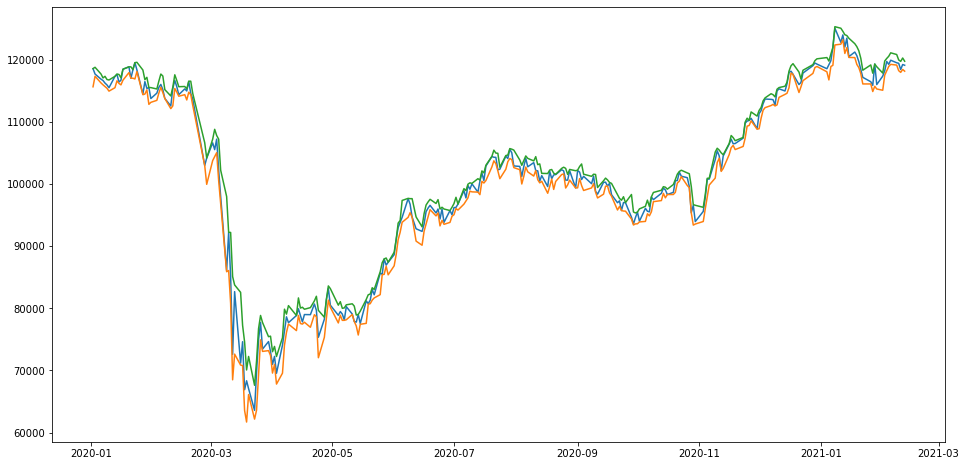

In [34]:
#setting index as date
DataSet['Date'] = pd.to_datetime (DataSet.Date)
DataSet.index = DataSet ['Date']

#trama
plt.figure (figsize = (16,8))
plt.plot (DataSet ['Close'], label = 'Fechar histórico de preços')

plt.plot (DataSet ['Low'], label = 'Baixa')
plt.plot (DataSet ['High'], label = 'Alta')




#plt.scatter(DataSet['Date'],DataSet['Open'],)
#plt.show()

base_treinamento = DataSet.iloc[:, 1:5].values

#DataSet.drop(['Date','Close','High','Low', 'Volume'],axis=1,inplace=True)

### Normalizar os dados do Mini Índice

In [35]:
from sklearn.preprocessing import MinMaxScaler

scaler=MinMaxScaler(feature_range=(0,1))
DataScaled=scaler.fit_transform(base_treinamento)

scaler_previsao = MinMaxScaler(feature_range=(-1,1))
scaler_previsao.fit_transform(base_treinamento[:,0:1])



array([[ 0.69341641],
       [ 0.78816027],
       [ 0.7602772 ],
       [ 0.73310992],
       [ 0.72644011],
       [ 0.71280767],
       [ 0.70304697],
       [ 0.68856859],
       [ 0.74784858],
       [ 0.75783703],
       [ 0.71824112],
       [ 0.72783914],
       [ 0.7853622 ],
       [ 0.79782336],
       [ 0.73841324],
       [ 0.7825316 ],
       [ 0.81952465],
       [ 0.78110003],
       [ 0.65534968],
       [ 0.72081144],
       [ 0.68440403],
       [ 0.68905663],
       [ 0.63189146],
       [ 0.66019749],
       [ 0.69052073],
       [ 0.7058125 ],
       [ 0.67838493],
       [ 0.63221682],
       [ 0.59327162],
       [ 0.68427389],
       [ 0.72621236],
       [ 0.6937743 ],
       [ 0.65206357],
       [ 0.68225667],
       [ 0.67161751],
       [ 0.7215923 ],
       [ 0.65870085],
       [ 0.36997934],
       [ 0.28125458],
       [ 0.32277009],
       [ 0.39987962],
       [ 0.36441574],
       [ 0.41897805],
       [ 0.25675522],
       [ 0.11851117],
       [-0

In [36]:
print(DataScaled)

[[0.8467082  0.88303881 0.87685257 0.89425594]
 [0.89408014 0.88683299 0.90434867 0.88017624]
 [0.8801386  0.86803534 0.88692798 0.8666981 ]
 ...
 [0.90885133 0.90322245 0.91457033 0.891931  ]
 [0.89206292 0.91266459 0.92220814 0.90501894]
 [0.90605326 0.90365558 0.91770671 0.9030842 ]]


### Definição dos previsores

In [37]:
previsores = []
preco_real = []
NRecursao = 20
NPrevisores=4
MPrevisoes=6
DataSetLen = len(DataScaled)
print(DataSetLen)

276


In [38]:

for i in range(NRecursao, DataSetLen):
    previsores.append(DataScaled[i-NRecursao:i,0])
    preco_real.append(DataScaled[i,0])

previsores, preco_real = np.array(previsores), np.array(preco_real)

### Estrutura da Rede Neural

In [39]:
# Camada de entrada
regressor = Sequential()
regressor.add(LSTM(units = 100, return_sequences = True, input_shape = (previsores.shape[1], NPrevisores)))
regressor.add(Dropout(0.3))

# Cada Oculta 1
regressor.add(LSTM(units = 150, return_sequences = True))
regressor.add(Dropout(0.3))

# Cada Oculta 2
regressor.add(LSTM(units = 200, return_sequences = True))
regressor.add(Dropout(0.3))

# Cada Oculta 3
regressor.add(LSTM(units = 100))
regressor.add(Dropout(0.3))

# Camada de Saída
regressor.add(Dense(units = MPrevisoes, activation = 'sigmoid'))


### Construindo a Rede

In [ ]:
regressor.compile(optimizer = 'rmsprop', loss = 'mean_squared_error',
                  metrics = ['mean_absolute_error'])

#Funções de Callback
es = EarlyStopping(monitor = 'loss', min_delta = 1e-10, patience = 10, verbose = 1)
rlr = ReduceLROnPlateau(monitor = 'loss', factor = 0.2, patience = 8, verbose = 1)
mcp = ModelCheckpoint(filepath = 'pesos.h5', monitor = 'loss', 
                      save_best_only = True, verbose = 1)
regressor.fit(previsores, preco_real, epochs = 1000, batch_size = 64,
              callbacks = [es, rlr, mcp])

### Conjunto de dados para o Teste

In [43]:
DataSet_teste=pd.read_csv('FuturosMiniBovespaMaio.csv')
DataSet_teste=DataSet_teste.dropna()
DataSet_teste.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2021-04-01,116644.0,117088.0,114991.0,115253.0,115253.0,8009200
1,2021-04-05,115262.0,117668.0,115262.0,117518.0,117518.0,7245100
2,2021-04-06,117519.0,118213.0,117176.0,117499.0,117499.0,6800800
3,2021-04-07,117499.0,118303.0,116748.0,117624.0,117624.0,0
4,2021-04-08,117624.0,118850.0,117486.0,118313.0,118313.0,8778200


In [44]:
# Preparação dos dados de teste no formato para a RNN

frames = [DataSet, DataSet_teste]
base_completa = pd.concat(frames)

base_completa= base_completa.drop(['Date','Adj Close','Volume'], axis = 1)


In [45]:
entradas = base_completa[len(base_completa) - len(DataSet_teste) - NRecursao:].values
entradas = scaler.transform(entradas)

entradas.shape

(47, 4)

In [46]:
preco_real_teste = DataSet_teste.iloc[:, 5:6].values

In [47]:
entradas = base_completa[len(base_completa) - len(DataSet_teste) - NRecursao:].values
entradas = scaler.transform(entradas)

entradas.shape

(47, 4)

In [48]:
DataSetTestLen = len(DataSet_teste)

X_teste = []
for i in range(NRecursao, DataSetTestLen+NRecursao):
    X_teste.append(entradas[i-NRecursao:i, 0:NPrevisores])
    
X_teste = np.array(X_teste)
X_teste.shape

(27, 20, 4)

In [49]:
previsoes = regressor.predict(X_teste)

previsoes = scaler_previsao.inverse_transform(previsoes)

print(previsoes.mean())
print(preco_real_teste.mean())

109933.87
119566.88888888889


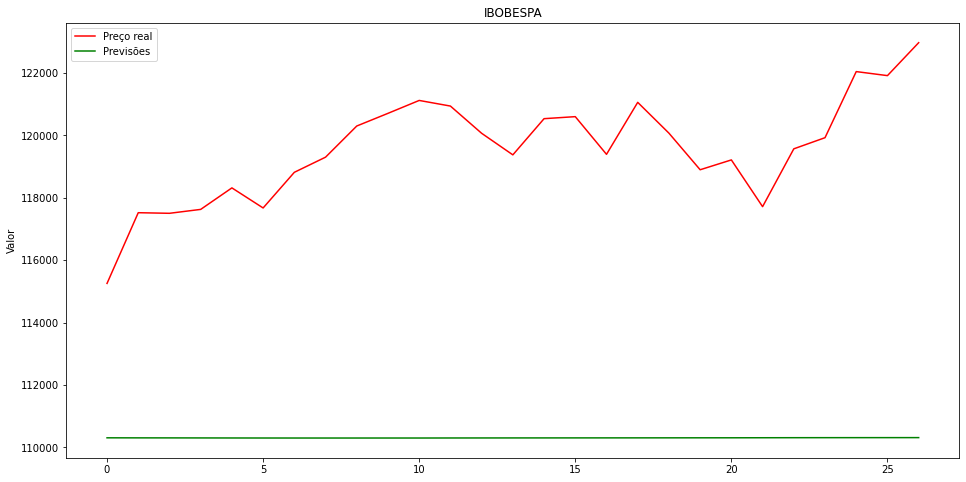

In [50]:
plt.figure (figsize = (16,8))

plt.plot(preco_real_teste, color = 'red', label = 'Preço real')
plt.plot(previsoes[:,[0]], color ='green', label = 'Previsões')
#plt.plot(RNN, color = 'green', label = 'R[:,[0]]NN')


plt.title('IBOBESPA')
#plt.xlabel('Tempo')
plt.ylabel('Valor')
plt.legend()
plt.show()